In [1]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def text_to_grid(text="xpektra", n=128, font_size_ratio=0.6):
    """
    Generate a 2D numpy array of size n x n containing a binary image
    of the given text centered in the grid.

    Parameters
    ----------
    text : str
        The text to render (default: 'xpektra').
    n : int
        The size of the grid (n x n pixels).
    font_size_ratio : float
        Fraction of the grid height used for font size (default: 0.6).

    Returns
    -------
    grid : np.ndarray
        A binary array (n, n) with 1 where text appears and 0 elsewhere.
    """
    # Create a blank image
    img = Image.new("L", (n, n), 0)
    draw = ImageDraw.Draw(img)
    
    # Choose a font (default font used if none available)
    font_size = int(n * font_size_ratio)
    try:
        font = ImageFont.truetype("DejaVuSans-Bold.ttf", font_size)
    except IOError:
        font = ImageFont.load_default()

    # Get text bounding box
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

    # Center position
    x = (n - text_width) // 2
    y = (n - text_height) // 2

    # Draw text in white (255)
    draw.text((x, y), text, fill=255, font=font)

    # Convert to numpy binary array
    grid = np.array(img)
    grid = (grid > 127).astype(int)
    
    return grid


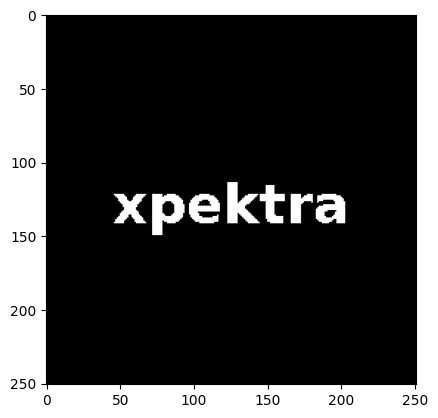

In [101]:
import matplotlib.pyplot as plt

phase = text_to_grid("xpektra", n=251, font_size_ratio=0.15)
plt.imshow(phase, cmap="gray")

plt.show()

In [102]:
import jax

jax.config.update("jax_enable_x64", True)  # use double-precision
jax.config.update("jax_platforms", "cpu")
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
import jax.numpy as jnp
import numpy as np
from jax import Array
import equinox as eqx

import matplotlib.pyplot as plt
from xpektra import (
    SpectralSpace,
    TensorOperator,
    make_field,
)
from xpektra.scheme import RotatedDifference, Fourier, ForwardDifference
from xpektra.projection_operator import GalerkinProjection
from xpektra.solvers.nonlinear import (  # noqa: E402
    conjugate_gradient_while,
    newton_krylov_solver,
)


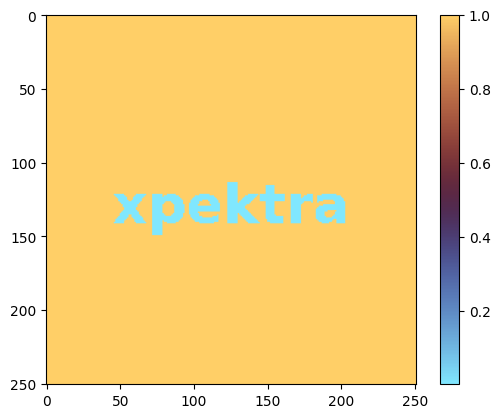

In [103]:
N = phase.shape[0]
ndim = 2
length = 1

tensor = TensorOperator(dim=ndim)
space = SpectralSpace(size=N, dim=ndim, length=length)


# Material parameters [grids of scalars, shape (N,N,N)]
lambda1, lambda2 = 1.0, 1e-3
mu1, mu2 = 0.25, 0.25
lambdas = lambda1 * (1.0 - phase) + lambda2 * phase
mu = mu1 * (1.0 - phase) + mu2 * phase


cb = plt.imshow(lambdas, cmap="managua_r")
plt.colorbar(cb)
plt.show()

In [104]:


dofs_shape = make_field(dim=ndim, N=N, rank=2).shape


@eqx.filter_jit
def strain_energy(eps_flat: Array) -> Array:
    eps = eps_flat.reshape(dofs_shape)
    eps_sym = 0.5 * (eps + tensor.trans(eps))
    energy = 0.5 * jnp.multiply(lambdas, tensor.trace(eps_sym) ** 2) + jnp.multiply(
        mu, tensor.trace(tensor.dot(eps_sym, eps_sym))
    )
    return energy.sum()


compute_stress = jax.jacrev(strain_energy)


Ghat = GalerkinProjection(
    scheme=RotatedDifference(space=space), tensor_op=tensor
).compute_operator()


class Residual(eqx.Module):
    """A callable module that computes the residual vector."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    # We can even pre-define the stress function if it's always the same
    # For this example, we'll keep your original `compute_stress` function
    # available in the global scope.

    @eqx.filter_jit
    def __call__(self, eps_flat: Array) -> Array:
        """
        This makes instances of this class behave like a function.
        It takes only the flattened vector of unknowns, as required by the solver.
        """
        eps_flat = eps_flat.reshape(-1)
        sigma = compute_stress(eps_flat)
        residual_field = self.space.ifft(
            self.tensor_op.ddot(
                self.Ghat, self.space.fft(sigma.reshape(self.dofs_shape))
            )
        )
        return jnp.real(residual_field).reshape(-1)


class Jacobian(eqx.Module):
    """A callable module that represents the Jacobian operator (tangent)."""

    Ghat: Array
    space: SpectralSpace = eqx.field(static=True)
    tensor_op: TensorOperator = eqx.field(static=True)
    dofs_shape: tuple = eqx.field(static=True)

    @eqx.filter_jit
    def __call__(self, deps_flat: Array) -> Array:
        """
        The Jacobian is a linear operator, so its __call__ method
        represents the Jacobian-vector product.
        """

        deps_flat = deps_flat.reshape(-1)
        dsigma = compute_stress(deps_flat)
        jvp_field = self.space.ifft(
            self.tensor_op.ddot(
                self.Ghat, self.space.fft(dsigma.reshape(self.dofs_shape))
            )
        )
        return jnp.real(jvp_field).reshape(-1)


applied_strains = jnp.diff(jnp.linspace(0, 1e-1, num=2))

deps = make_field(dim=2, N=N, rank=2)
eps = make_field(dim=2, N=N, rank=2)

residual_fn = Residual(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)
jacobian_fn = Jacobian(Ghat=Ghat, space=space, tensor_op=tensor, dofs_shape=eps.shape)


for inc, deps_avg in enumerate(applied_strains):
    # solving for elasticity
    deps[:, :, 0, 0] = deps_avg
    deps[:, :, 1, 1] = deps_avg

    b = -residual_fn(deps)
    eps = eps + deps

    final_state = newton_krylov_solver(
        state=(deps, b, eps),
        gradient=residual_fn,
        jacobian=jacobian_fn,
        tol=1e-8,
        max_iter=20,
        krylov_solver=conjugate_gradient_while,
        krylov_tol=1e-8,
        krylov_max_iter=20,
    )
    eps = final_state[2]

eps = final_state[2].reshape(dofs_shape)
sig = compute_stress(final_state[2]).reshape(dofs_shape)


CG error = 75.84651724222920
Converged, Residual value : 2.2839933409951885e-13


In [106]:
from cmap import Colormap

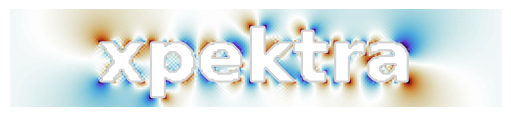

In [165]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
mask = phase == 1
eps_comp = eps.at[:, :, 0, 1].get()
#mask2 = np.abs(eps_comp) < 0.001
#mask = mask | mask2
eps_masked = np.ma.array(eps_comp, mask=mask)

cb1 = ax1.imshow(
    eps_masked[int(N/2)-20:int(N/2)+30, :],
    cmap=Colormap("fusion").to_mpl(),
)

#eps_masked = np.ma.array(eps.at[:, :, 0, 1].get(), mask=~mask)

#ax1.imshow(eps_masked[int(N/2)-10:int(N/2)+20, :], cmap="managua_r", alpha=0.5)
ax1.contour(phase[int(N/2)-20:int(N/2)+30, :], colors="lightgrey", levels=[0.5])
#ax1.contour(eps_masked[int(N/2)-40:int(N/2)+60, :], cmap=Colormap("fusion").to_mpl(), levels=16) #cmap=Colormap("fusion").to_mpl(), levels=4)
#fig.colorbar(cb1)
ax1.axis("off")
plt.savefig("xpektra_fft.svg")

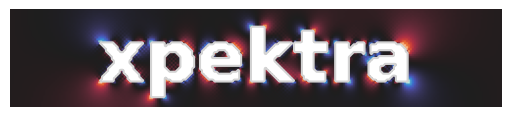

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 5), layout="constrained")
mask = phase == 1
eps_comp = eps.at[:, :, 0, 1].get()
#mask2 = np.abs(eps_comp) < 0.001
#mask = mask | mask2
eps_masked = np.ma.array(eps_comp, mask=mask)

cb1 = ax1.imshow(
    eps_masked[int(N/2)-20:int(N/2)+30, :],
    cmap=Colormap("icefire").to_mpl(),  
)

#eps_masked = np.ma.array(eps.at[:, :, 0, 1].get(), mask=~mask)

#ax1.imshow(eps_masked[int(N/2)-10:int(N/2)+20, :], cmap="managua_r", alpha=0.5)
ax1.contour(phase[int(N/2)-20:int(N/2)+30, :], colors="lightgrey", levels=[0.5])
#ax1.contour(eps_masked[int(N/2)-40:int(N/2)+60, :], cmap=Colormap("fusion").to_mpl(), levels=16) #cmap=Colormap("fusion").to_mpl(), levels=4)
#fig.colorbar(cb1)
ax1.axis("off")
plt.savefig("xpektra_dark_fft.svg")